# Objective:
1. Identify Accuracy Score for 

Individual Models AND Ensemble: 
- LogisticRegression, 
- KNeighborsClassifier, 
- DecisionTreeClassifier, 
- SVM, 
- GaussianNB, 
- Ensemble



# Result (Accuracy) : 
- lr 0.749
- knn 0.801 
- cart 0.812
- svm 0.820 
- bayes 0.683
- stacking 0.841 

# Import Libraries

In [10]:
print('Innit Importing Library...')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

Innit Importing Library...


# Read Data

In [11]:
print('Innit Reading DataFrame...')

fpath = '/content/mydrive/MyDrive/personal_data/Random_Data/REA/name_gender.csv'
fpath = 'name_gender.csv'
import pandas as pd
df = pd.read_csv(fpath)
print(df)

Innit Reading DataFrame...
       Unnamed: 0          name gender
0               0      kintrell      M
1               1      quinnell      M
2               2      tylerlee      M
3               3        quincy      M
4               4        slavko      M
...           ...           ...    ...
69437       69437          ikem      M
69438       69438        gradie      M
69439       69439      gaibriel      M
69440       69440       vermont      M
69441       69441  jorgeantonio      M

[69442 rows x 3 columns]


# Clean Data

In [13]:
print('Innit Cleaning DataFrame...')
import re
# string with letters, numbers, and special characters
def clean_letters(s):
    # s = "BuckyBarnes@123"
    # keep only letters
    res = re.sub(r'[^a-zA-Z]', '', s)
    return res
df['name']=df['name'].apply(lambda x: clean_letters(x))
# print(len(df))
print(df.head())

Innit Cleaning DataFrame...
   Unnamed: 0      name gender
0           0  kintrell      M
1           1  quinnell      M
2           2  tylerlee      M
3           3    quincy      M
4           4    slavko      M


In [14]:
df.drop_duplicates(subset=['name'],inplace=True)

In [15]:
columnsTitles=["name","gender"]
df=df.reindex(columns=columnsTitles)
df
df['name'] = df['name'].apply(lambda x: str(x).lower())

df = df[[len(e)>1 for e in df.name]]
df = df.drop_duplicates()

names = df['name'].apply(lambda x: x.lower())
gender = df['gender']

df.head()

,name,gender
0,kintrell,M
1,quinnell,M
2,tylerlee,M
3,quincy,M
4,slavko,M


In [16]:
maxlen = 20
labels = 2

In [17]:
print("Male : " + str(sum(gender=='M')))
print("Female : " + str(sum(gender=='F')))

Male : 34721
Female : 34721


# Label character index as numerical inputs to LSTM

In [18]:
print('Innit Labelling character index as numerical inputs to LSTM')
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)

Innit Labelling character index as numerical inputs to LSTM


In [19]:
char_index = dict((c, i) for i, c in enumerate(vocab))
print("char_index:",char_index)

char_index: {'c': 0, 'o': 1, 'a': 2, 'END': 3, 'h': 4, 'z': 5, 'v': 6, 'r': 7, 't': 8, 'm': 9, 'd': 10, 'e': 11, 'u': 12, ' ': 13, 's': 14, 'j': 15, 'q': 16, 'x': 17, 'k': 18, 'f': 19, 'y': 20, 'n': 21, 'l': 22, 'b': 23, 'w': 24, 'p': 25, 'g': 26, 'i': 27}


In [20]:
print('Prepareing input from character_index...')
X = []
y = []

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


# Label Encoding of y
def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list

X = prepare_X(names.values)
y = prepare_y(gender)

print("X[:5]:",X[:5])
print("y[:5]:",y[:5])

Prepareing input from character_index...
X[:5]: [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [21]:
print('Innit sklearn.preprocessing train_test_split')
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train_ =np.argmax(X_train, axis=1)
y_train_ =np.argmax(y_train, axis=1)

Innit sklearn.preprocessing train_test_split


# Stacking

In [22]:
print('Innitiate Stacking and Ensemble.. Results might take awhile to run if on docker')

Innitiate Stacking and Ensemble.. Results might take awhile to run if on docker


>lr 0.749 (0.004)
>knn 0.801 (0.004)
>cart 0.812 (0.004)
>svm 0.820 (0.004)
>bayes 0.683 (0.005)
>stacking 0.841 (0.004)


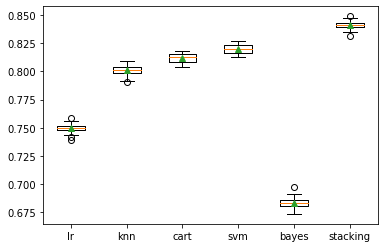

In [43]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
 
# get the dataset
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# define dataset
# X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_, y_train_)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


# Result (Accuracy) : 
- lr 0.749
- knn 0.801 
- cart 0.812
- svm 0.820 
- bayes 0.683
- stacking 0.841 